## Creating Dummy Dataset

In [ ]:
import random
import pandas as pd

sentiment_categories = {
    "Joyful": [
        "I love this product! It's absolutely amazing.",
        "The customer service was excellent and very helpful.",
        "This is the best experience I have had in a long time.",
        "I am so happy with my purchase. Highly recommend it!",
        "Great quality and fantastic value for money.",
        "The app is user-friendly and works perfectly.",
        "I had a wonderful time at the restaurant. The food was delicious!",
        "Fantastic movie! The storyline was engaging and well-executed.",
        "This service exceeded my expectations in every way.",
        "Very satisfied with the results. Would buy again."
    ],
    "Frustrated": [
        "I hate this product. It's absolutely terrible.",
        "The customer service was rude and unhelpful.",
        "This is the worst experience I have had in a long time.",
        "I regret my purchase. Do not recommend it!",
        "Poor quality and a waste of money.",
        "The app is slow, buggy, and crashes frequently.",
        "I had a horrible time at the restaurant. The food was awful!",
        "Terrible movie! The storyline was boring and poorly executed.",
        "This service was a complete disappointment.",
        "Very dissatisfied with the results. Never buying again."
    ],
    "Excited": [
        "I can't wait to use this again, it's so good!",
        "This event was thrilling and exceeded my expectations!",
        "What an incredible opportunity, I'm beyond excited!",
        "This is the most exciting thing I've ever experienced.",
        "I'm so pumped about this new feature, it's revolutionary!",
        "Absolutely mind-blowing, I feel so energized!",
        "This is the kind of innovation that gets me truly excited.",
        "The thrill of using this is unmatched!",
        "I was on the edge of my seat the whole time!",
        "Incredible! The experience left me feeling so alive!"
    ],
    "Disappointed": [
        "I expected much better, this was a huge letdown.",
        "This did not meet my expectations at all.",
        "I'm really disappointed, I thought it would be much better.",
        "Such a waste of time and money, very let down.",
        "The hype was not justified, I feel let down.",
        "Not what I hoped for, left feeling disappointed.",
        "This service has really gone downhill, very sad.",
        "A major disappointment, wouldn't recommend at all.",
        "Fell short in every way, I wouldn't use it again.",
        "This left me feeling extremely unsatisfied."
    ]
}

num_samples = 100

data = []
for _ in range(num_samples):
    label = random.choice(list(sentiment_categories.keys()))
    sentence = random.choice(sentiment_categories[label])
    data.append((sentence, label))

df_sentiment_100 = pd.DataFrame(data, columns=["Sentence", "Label"])

df_sentiment_100.to_csv("random_sentiment_dataset_100.csv", index=False)

print(df_sentiment_100.head())


                                            Sentence         Label
0  I am so happy with my purchase. Highly recomme...        Joyful
1          This did not meet my expectations at all.  Disappointed
2  This is the best experience I have had in a lo...        Joyful
3  The customer service was excellent and very he...        Joyful
4      The app is user-friendly and works perfectly.        Joyful


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

## Data Preparation

In [ ]:
df = pd.read_csv("random_sentiment_dataset_100.csv")

all_words = set(word.lower() for sentence in df["Sentence"] for word in sentence.split())
word_to_index = {word: i+1 for i, word in enumerate(all_words)}
index_to_word = {i: word for word, i in word_to_index.items()}

label_mapping = {"Joyful": 0, "Frustrated": 1, "Excited": 2, "Disappointed": 3}
df["Label"] = df["Label"].map(label_mapping)

sentence_lengths = [len(sentence.split()) for sentence in df["Sentence"]]
SEQ_LEN = 15

def tokenize(sentence):
    tokens = [word_to_index[word.lower()] for word in sentence.split() if word.lower() in word_to_index]
    return tokens[:SEQ_LEN] + [0] * (SEQ_LEN - len(tokens))  # Pad sequences to SEQ_LEN

df["Tokenized"] = df["Sentence"].apply(tokenize)

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, dataframe):
        self.sentences = dataframe["Tokenized"].tolist()
        self.labels = dataframe["Label"].tolist()

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return torch.tensor(self.sentences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

BATCH_SIZE = 32
train_dataset = SentimentDataset(train_data)
test_dataset = SentimentDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Position Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, max_seq_len, d_model) * 0.01)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.positional_encoding[:, :seq_len, :]

In [ ]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, max_seq_len, num_classes, dropout=0.2):
        super(Transformer, self).__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)

        self.positional_encoding = PositionalEncoding(max_seq_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads, dim_feedforward=4*d_model, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.fc1 = nn.Linear(d_model, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.layer_norm = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.layer_norm(x)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
vocab_size = len(word_to_index) + 1
d_model = 128
num_heads = 8
num_layers = 3
max_seq_len = SEQ_LEN
num_classes = 4
num_epochs = 30
learning_rate = 1e-4

model = Transformer(vocab_size, d_model, num_heads, num_layers, max_seq_len, num_classes, dropout=0.2)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
model

Transformer(
  (embedding): Embedding(169, 128)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (la

## Model Training

In [ ]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        correct += (output.argmax(1) == batch_y).sum().item()
        total += batch_y.size(0)

    train_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.2%}")

    scheduler.step()

Epoch 1/30, Loss: 3.1090, Accuracy: 72.50%
Epoch 2/30, Loss: 3.0836, Accuracy: 70.00%
Epoch 3/30, Loss: 2.9948, Accuracy: 71.25%
Epoch 4/30, Loss: 3.0841, Accuracy: 65.00%
Epoch 5/30, Loss: 2.8746, Accuracy: 75.00%
Epoch 6/30, Loss: 2.9707, Accuracy: 71.25%
Epoch 7/30, Loss: 3.0921, Accuracy: 66.25%
Epoch 8/30, Loss: 2.9234, Accuracy: 70.00%
Epoch 9/30, Loss: 2.8061, Accuracy: 75.00%
Epoch 10/30, Loss: 2.7659, Accuracy: 71.25%
Epoch 11/30, Loss: 2.7490, Accuracy: 78.75%
Epoch 12/30, Loss: 2.8461, Accuracy: 76.25%
Epoch 13/30, Loss: 2.8709, Accuracy: 68.75%
Epoch 14/30, Loss: 2.7277, Accuracy: 75.00%
Epoch 15/30, Loss: 2.6835, Accuracy: 75.00%
Epoch 16/30, Loss: 2.6814, Accuracy: 73.75%
Epoch 17/30, Loss: 2.7905, Accuracy: 77.50%
Epoch 18/30, Loss: 2.6728, Accuracy: 75.00%
Epoch 19/30, Loss: 2.5974, Accuracy: 80.00%
Epoch 20/30, Loss: 2.5563, Accuracy: 81.25%
Epoch 21/30, Loss: 2.6302, Accuracy: 80.00%
Epoch 22/30, Loss: 2.6249, Accuracy: 72.50%
Epoch 23/30, Loss: 2.5465, Accuracy: 77.5

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        output = model(batch_X)
        predicted = torch.argmax(output, dim=1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

accuracy = correct / total
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

Final Test Accuracy: 70.00%


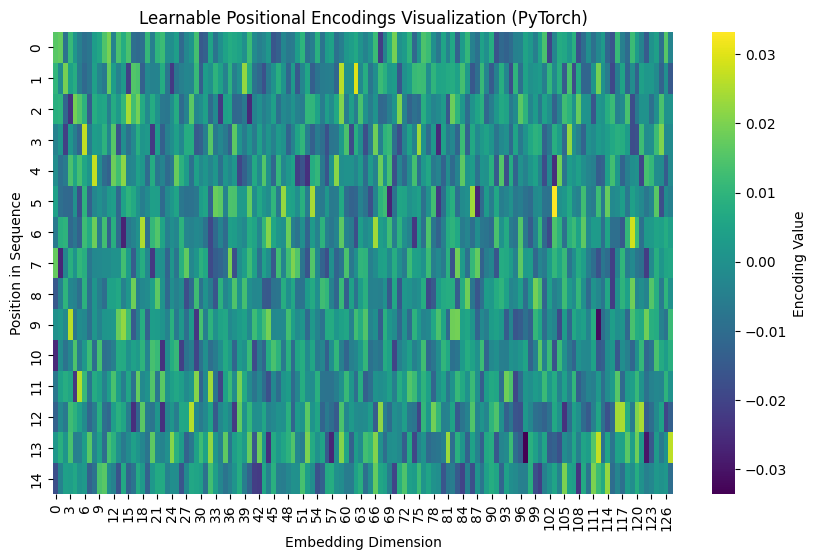

In [ ]:
positional_encodings = model.positional_encoding.positional_encoding.squeeze(0).cpu().detach().numpy()

plt.figure(figsize=(10, 6))
sns.heatmap(positional_encodings, annot=False, cmap="viridis", cbar=True, cbar_kws={'label': 'Encoding Value'})
plt.xlabel("Embedding Dimension")
plt.ylabel("Position in Sequence")
plt.title("Learnable Positional Encodings Visualization (PyTorch)")
plt.show()